#### Template

*This Notebook is part of a Github Repository Template defining a Project File Structure. (See README.md)*

```.
├── config.yaml
├── data
│   └── README_data.md
├── environment.yaml
├── README.md
├── scripts
│   ├── clean.sh
│   ├── downsample.sh
│   ├── generate_reference.sh
│   ├── nb2py.sh
│   ├── README_scripts.md
│   └── run_ubs_seq.sh
├── src
│   └── README_IGV_WEB.md
└── workspace
    ├── README_workspace.md
    ├── ubs_basic.ipynb
    └── ubs_basic.py
```

In [1]:
from pathlib import Path
home_path      = Path.cwd()/'..'
workspace_path = home_path/'workspace'

# UBS-seq Pipeline
## Basic Workflow

**C. Bryan Daniels**

**3/1/2024**

## Project: UBS-seq Basic Pipeline

The purpose of this project is run a minimally viable UBS-seq pipline. For simplicity, it will run several single-end samples, mapping only to the genome. The core steps of the pipeline are:
- cut_apapter
- quality_control
- align2ref
- sort2ref
- dedupe
- filter->all_multi_unique
- call_peaks
- select_groups
- analysis_and_annotation

This pipeline is based upon the paper by [Qing Dai, etal](https://doi.org/10.1038/s41587-023-02034-w) and the UBS-seq pipeline developed by [Chang Ye](https://github.com/y9c/m5C-UBSseq)



## Setup

#### The logic for the Pipeline is defined through a series of Steps using dirs to save intermediate results
1. For each **Step** in the pipeline a dir will be created and labeled **Step** and will contain all files created by that **Step**
2. Within a **Step**, **in_path** and **out_path** will generically refer to the prior and current **Step**
3. Within each **Step**, the appropriate processes will occur. Generally this involves processing files from **in_path** and saving to **out_path**
4. **Abbreviated filenames** should not change through the pipeline (suffixes will reflect current file formats). The dir name should reflect the **Step**, not the filename.
6. The function **mkpath(step)** returns a path for a dir **Step**. It will create a dir if need be, but not overwrite an existing dir
8. The function **fname(path,sample,suffix)** returns a file name without actually creating the file

#### Convert Notebook to Script to Execute from the Command Line

```
# cd workplace/
# juptyer nbconvert ubs_basic.ipynb --to script
# ipython ubs_basic.py
```

#### Environment

In [2]:
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
from IPython.display import display, HTML
from snakemake import load_configfile

In [3]:
os.environ['PATH'] = f"{str(home_path)}:" + os.environ['PATH'] # home_path
os.environ['PATH'] = '/home/cdaniels/bin/homer:' + os.environ['PATH'] # homer
os.environ['PATH'] = '/home/cdaniels/bin/hisat-3n:' + os.environ['PATH'] # hisat-3n
os.environ['_JAVA_OPTIONS'] = '-Xmx8g' # Set Java Flag

In [4]:
nc = get_ipython().getoutput('nproc') # Number of cores  
nc = int(nc[0]); nc

32

#### Functions

In [5]:
sys.path.append(f"{home_path}/scripts/") # scripts/
from configure import samples, data, sample2data, group2sample, group2run # scripts/configure.py
from utils import *

In [6]:
mkpath?

Signature: mkpath(path)
Docstring: Return dir path name; creates (not over-writting) a new dir within the pwd. Also prints date/time executed
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/utils.py
Type:      function

In [7]:
fname?

Signature: fname(path, base, sufix)
Docstring: Return a path and suffix complete filename
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/utils.py
Type:      function

In [8]:
samples?

Signature: samples(n=2, se=True, keys=False, extra=[])
Docstring:
Generates iterators of sample names as defined in 'sample2data'
- n=1 returns an iterator of biological replicates, sample(2) -> ['t1', 't2', 'c1']
- n=2 (default) returns an iterator of biologial replicates and runs -> ['t1_r1', 't2_r1', 'c1_r1']
- se=True (default) filters for SE reads, se=False filters for PE reads
- keys=True returns an iterator of tuples of length 'n'. When iterated will require 'n' handles -> [('t1', 'r1'), ('t2', 'r1'), ('c1', 'r1')]
- extra=[alist] returns an iterator which is the Cartesian product of the elements of alist and the original iterator.

Example:
samples(keys=True, extra=['gene','genome']) ->
 [('t1', 'r1', 'gene'), ('t1', 'r1', 'genome'), ('t2', 'r1', 'gene'), ('t2', 'r1', 'genome'), ('c1', 'r1', 'gene'), ('c1', 'r1', 'genome')]
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/configure.py
Type:      function

In [9]:
data?

Signature: data(type='SE')
Docstring:
Generates iterator of data paths as defined in `sample2data`
- type='SE' will flatten the list and return a single path per tuple
- type='PE' will return a list of R1 and R2 and data paths

Example:
data() -> [('t1_r1', PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/scripts/../data/test1_R1.fq.gz')),
           ('t2_r1', PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/scripts/../data/test2_R1.fq.gz')),
           ('c1_r1', PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/scripts/../data/test3_R1.fq.gz'))]
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/configure.py
Type:      function

#### Configuration file

Use `config.yaml` to configure `references/` and `samples`

In [9]:
config = load_configfile(home_path/"config.yaml")

In [10]:
genome_fa  = home_path/config['reference']['genome']['fa']
genome_idx = home_path/config['reference']['genome']['hisat3n']
genes_fa   = home_path/config['reference']['genes']['fa']
genes_idx  = home_path/config['reference']['genes']['hisat3n']

## Step: select_samples

#### Define sample names and link to sample files

In [11]:
out_path = mkpath('select_samples')

>>> {select_samples} 22:45:28_03-09-2024


Samples were obtained from NCBI using the SRR ID

|ID|Group  | Description                                             |SRR        |
|:-|-------|---------------------------------------------------------|-----------|
|t1|treated|WT HeLa polyA+ RNA treated with ultrafast BS, replicate 1|SRR23538292|
|t2|treated|WT HeLa polyA+ RNA treated with ultrafast BS, replicate 2|SRR23538291|
|c1|control|WT HeLa polyA+ RNA treated with ultrafast BS, replicate 3|SRR23538290|

Define short sample names for samples in groups {treated, control}

In [12]:
treated, control = group2run['treated'], group2run['control']
print(treated)
print(control)

['t1_r1', 't2_r1']
['c1_r1']


Sample files

In [13]:
list(data())

[('t1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test1_R1.fq.gz')),
 ('t2_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test2_R1.fq.gz')),
 ('c1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test3_R1.fq.gz'))]

Symbolically link short names with sample files

In [14]:
for (s,fn) in data():
    ! ln -s {fn} {fname(out_path,s,"fq.gz")}

ln: failed to create symbolic link 'select_samples/t1_r1.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/t2_r1.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/c1_r1.fq.gz': File exists


Check that the files look correct

In [16]:
!ls -lLh {out_path}

total 131M
-rw-rw-r-- 1 cdaniels cdaniels 47M Mar  2 20:55 c1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 37M Mar  2 20:54 t1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 49M Mar  2 20:55 t2_r1.fq.gz


How many sequence reads do we have per Sample

In [17]:
# Total Reads per Samples
for sample in samples():
    !samtools view -c {fname(out_path, sample, 'fq.gz')}

935632
1365245
1183321


## Step: fastqc_pre

#### Pre Trimming Quality Control

In [18]:
in_path = mkpath("select_samples")
out_path = mkpath("fastqc_pre")

>>> {select_samples} 22:46:52_03-09-2024
>>> {fastqc_pre} 22:46:52_03-09-2024


#### fastqc

In [22]:
#! fastqc --help

##### paramaters:
- -o output dir

In [19]:
for sample in samples():
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1_r1.fq.gz
application/gzip
Analysis complete for t2_r1.fq.gz
application/gzip
Analysis complete for c1_r1.fq.gz


In [20]:
! ls -l {out_path}

total 3052
-rw-rw-r-- 1 cdaniels cdaniels 653105 Mar  9 22:47 c1_r1_fastqc.html
-rw-rw-r-- 1 cdaniels cdaniels 400410 Mar  9 22:47 c1_r1_fastqc.zip
-rw-rw-r-- 1 cdaniels cdaniels 647161 Mar  9 22:47 t1_r1_fastqc.html
-rw-rw-r-- 1 cdaniels cdaniels 383358 Mar  9 22:47 t1_r1_fastqc.zip
-rw-rw-r-- 1 cdaniels cdaniels 650114 Mar  9 22:47 t2_r1_fastqc.html
-rw-rw-r-- 1 cdaniels cdaniels 382881 Mar  9 22:47 t2_r1_fastqc.zip


## Step: trim

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence

In [21]:
in_path = mkpath("select_samples")
out_path = mkpath("trim")

>>> {select_samples} 22:47:20_03-09-2024
>>> {trim} 22:47:20_03-09-2024


![adapter](../img/adapter.png)

The adapter sequence contains the i7 primer + i7 index + p7 sequence, and all of them can be sequenced in the R1, if the insert fragment is too short. The reason that RNA seq library shows index at the end, and UBS-seq shows index within the sequence, is because UBS-seq library are too short and PE150 sequencing mode can read though the whole index.

Q: Where is barcode3?

In [22]:
adapter =  "AGATCGGAAGAGCACACGTCT"
barcode3 = "ATCACG"

In [23]:
!ls {in_path}

c1_r1.fq.gz  t1_r1.fq.gz  t2_r1.fq.gz


#### cutadapt

In [29]:
#! cutadapt --help

```
cutadapt -j {threads} 
            -n 2 
            -a "{params.barcode3}{params.adapter3};e=0.15;o=6;anywhere;" 
            --untrimmed-output={output.fastq_untrimmed} 
            -o - {input} 2>{output.report1} | 
cutadapt -j {threads} 
            -u 5 -u -5 
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}' 
            --max-n=0 
            -q 15 
            --nextseq-trim=15 
            -m 20 
            --too-short-output={output.fastq_tooshort} 
            -o {output.fastq_cut} - >{output.report2}
```

https://cutadapt.readthedocs.io/en/stable/guide.html

##### paramaters:
- -j 0, Number of CPU. Use 0 to autodetect
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- -a '{barcode3}{adapter};e=0.15;o=6;anywhere;', 
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

**NOTE:** Added `--length 30` to cutoff reads where C begin to become more common. Not in original code

In [24]:
for sample in samples():
    !cutadapt -j 0 -n 2 \
        -a '{barcode3}{adapter};e=0.15;o=6;anywhere;' \
        --untrimmed-output={fname(out_path,sample,'untrimmed')} \
        -o {fname(out_path,sample,'tmp')}\
        {fname(in_path,sample,'fq.gz')} > {fname (out_path,sample,'report1')} 
    
    !cutadapt -j 0 -u 5 -u -5 --max-n=0 -q 15 -m 20 --length 80 --nextseq-trim=15 \
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,'tooshort')} \
            -o {fname(out_path,sample,"fq.gz")} \
            {fname(out_path,sample,'tmp')} > {fname(out_path,sample,'report2')}
    
    !rm {fname(out_path,sample,'tmp')}

Done           00:00:00       935,632 reads @   0.9 µs/read;  67.00 M reads/minute
Done           00:00:01       910,046 reads @   1.1 µs/read;  52.58 M reads/minute
Done           00:00:01     1,365,245 reads @   0.8 µs/read;  70.82 M reads/minute
Done           00:00:01     1,335,535 reads @   1.1 µs/read;  55.87 M reads/minute
Done           00:00:01     1,183,321 reads @   0.9 µs/read;  67.30 M reads/minute
Done           00:00:01     1,158,613 reads @   1.0 µs/read;  57.73 M reads/minute


#### Analysis

Take a look at a FASTQ file

In [25]:
in_fn  = fname(in_path,treated[0],'fq.gz')
out_fn = fname(out_path,treated[0],'fq.gz')
out_fn

PosixPath('trim/t1_r1.fq.gz')

In [26]:
! zcat {in_fn}|head -16

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC
+
FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFF,FFF:F
@SRR23538290.144 144 length=121
TTTTTTTGGATATTAGGAAAAAATTTTGTAGAGAGAGTAAAAAATTTACTAGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTCTGCT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFF:,FF,F:FFFFFF
@SRR23538290.276 276 length=121
CCAGGAATTATAGTAATGTTTAGTTTATTGAGTTAAATGTTTGTCGGATGTGTTTGTGAGGGGATGAGGATGATAAGATTTTGTTTAGTATCACGAGATCGGAAGAGCACACGTCTGAACT
+
FF:,FFF:,FFF,FFF:FFFFFFFFFFFF,F:F:F:F,F,:,FFF,,F,F,,:,:,,FFFFF:FF:F,,F,,FF,F:,,,F,F,F:F::F::FFFFFFF:FFFF:FF,FFFFFFFFF,FFF
@SRR23538290.379 379 length=121
CCTCAAGAGTTTTAATGTTTTTAATGTAGGTGATGATTGGGAAAACACATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTCTTCTTGAAA
+
FFF,:,FFF:FF

In [27]:
def show_adapter(reads):
    for read in reads.split('\n'):
        read = read.replace(adapter, f'<span style="color: blue;">{barcode3}{adapter}</span>')
        display(HTML(read))

Look for adapter in untrimmed reads

In [28]:
reads = ! zcat {in_fn} | head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

Verify that adapters and all downstream elements of reads have been trimmed

In [29]:
reads = !zcat {out_fn}| head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

In [30]:
!ls {out_path}

c1_r1.fq.gz	c1_r1.untrimmed  t1_r1.tooshort   t2_r1.report2
c1_r1.report1	t1_r1.fq.gz	 t1_r1.untrimmed  t2_r1.tooshort
c1_r1.report2	t1_r1.report1	 t2_r1.fq.gz	  t2_r1.untrimmed
c1_r1.tooshort	t1_r1.report2	 t2_r1.report1


What did `--rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'` do?

It appears to has included in the fastq header, an id comprised of the first and last 5 nt cut by `-u 5` and `-u -5`

In [31]:
! zcat {in_fn}|head -2  

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC

gzip: stdout: Broken pipe


In [32]:
!zcat {out_fn}| head -2

@SRR23538290.50_GGAAAATGGT 50 length=121
TTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTT

gzip: stdout: Broken pipe


Too slow for large files. Commented out.

In [286]:
#files = [fname(in_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#ins = res
#ins

In [287]:
#files = [fname(out_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#outs = res
#outs

In [288]:
#make_table(ins, outs, "Origs", "Trimmed", "Sum of Total Read Lengths", samples, "Sum of Total Reads Per Sample")

In [289]:
#reads = !xargs zcat {out_path}/*.gz | seqtk seq -A  |grep -v ">" 
#ds = [len(read) for read in reads]
#make_histogram(ds, "Read Length", "Trimmed Reads")

## Step: fastqc_post

#### Post Trimming Quality Control

In [33]:
in_path = mkpath("trim")
out_path = mkpath("fastqc_post")

>>> {trim} 22:48:30_03-09-2024
>>> {fastqc_post} 22:48:30_03-09-2024


In [34]:
for sample in samples():
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1_r1.fq.gz
application/gzip
Analysis complete for t2_r1.fq.gz
application/gzip
Analysis complete for c1_r1.fq.gz


#### Consolidate fastqc Reports

In [35]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=781511;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.21 now available!
|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/fastqc_post
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 7/7  0/7  
|            fastqc | Found 3 reports
|           multiqc | Report      : fastqc_post/multiqc.html   (overwritten)
|           multiqc | Data        : fastqc_post/multiqc_data   (overwritten)
|           multiqc | MultiQC complete


In [36]:
! ls {out_path}

c1_r1_fastqc.html  multiqc_data  t1_r1_fastqc.html  t2_r1_fastqc.html
c1_r1_fastqc.zip   multiqc.html  t1_r1_fastqc.zip   t2_r1_fastqc.zip


## Step: map_se

#### Map Single Ended Reads with Hisat-3n

In [37]:
in_path = mkpath("trim")
out_path = mkpath("map_se")

>>> {trim} 22:48:57_03-09-2024
>>> {map_se} 22:48:57_03-09-2024


#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [464]:
#!hisat-3n --help

```
hisat3n --index {params.index} 
        -p {threads}
        --summary-file {output.summary} --new-summary -q -U {input} 
        {params.mapping} --all --norc --base-change C,T --mp 8,2 
        --no-spliced-alignment --un {output.fq} -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un {output.fq}, write unpaired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

#### Map Reads to Genes

This is a filtering step to remove reads aligned to reference genes including rRNA and tRNA

The unmapped reads are saved as `sample.genes.fq.gz`, which are subsequently mapped to the genome

In [38]:
for sample in samples():
    !hisat-3n --index {genes_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,"genes.summary")}\
        --new-summary -q\
        -U {fname(in_path,sample,'fq.gz')}\
        --directional-mapping --all --norc \
        --base-change C,T\
        --no-spliced-alignment --mp 8,2\
        --un {fname(out_path,sample,'genes.fq')}\
        -S {fname(out_path,sample,'genes.sam')}

HISAT2 summary stats:
	Total reads: 894555
		Aligned 0 time: 869716 (97.22%)
		Aligned 1 time: 9804 (1.10%)
		Aligned >1 times: 15035 (1.68%)
	Overall alignment rate: 2.78%
HISAT2 summary stats:
	Total reads: 1306170
		Aligned 0 time: 1268982 (97.15%)
		Aligned 1 time: 14344 (1.10%)
		Aligned >1 times: 22844 (1.75%)
	Overall alignment rate: 2.85%
HISAT2 summary stats:
	Total reads: 1134400
		Aligned 0 time: 1101752 (97.12%)
		Aligned 1 time: 11401 (1.01%)
		Aligned >1 times: 21247 (1.87%)
	Overall alignment rate: 2.88%


In [39]:
! ls {out_path}

c1_r1.genes.bam       t1_r1.genes.bam	    t2_r1.genes.bam
c1_r1.genes.bam.csi   t1_r1.genes.bam.csi   t2_r1.genes.bam.csi
c1_r1.genes.fq	      t1_r1.genes.fq	    t2_r1.genes.fq
c1_r1.genes.sam       t1_r1.genes.sam	    t2_r1.genes.sam
c1_r1.genes.summary   t1_r1.genes.summary   t2_r1.genes.summary
c1_r1.genome.bam      t1_r1.genome.bam	    t2_r1.genome.bam
c1_r1.genome.bam.csi  t1_r1.genome.bam.csi  t2_r1.genome.bam.csi
c1_r1.genome.fq       t1_r1.genome.fq	    t2_r1.genome.fq
c1_r1.genome.sam      t1_r1.genome.sam	    t2_r1.genome.sam
c1_r1.genome.summary  t1_r1.genome.summary  t2_r1.genome.summary


#### Map Reads to Genome

Reads mapped to the genome are saved as `sample.genome.sam` and used for subsequent steps in the pipeline

In [40]:
for sample in samples():
    !hisat-3n --index {genome_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,"genome.summary")}\
        --new-summary\
        -q\
        -U {fname(out_path,sample,'genes.fq')}\
        --directional-mapping\
        --base-change C,T\
        --pen-noncansplice 20\
        --mp 4,1\
        --un {fname(out_path,sample,'genome.fq')}\
        -S {fname(out_path,sample,'genome.sam')}

HISAT2 summary stats:
	Total reads: 869716
		Aligned 0 time: 73714 (8.48%)
		Aligned 1 time: 651997 (74.97%)
		Aligned >1 times: 144005 (16.56%)
	Overall alignment rate: 91.52%
HISAT2 summary stats:
	Total reads: 1268982
		Aligned 0 time: 122558 (9.66%)
		Aligned 1 time: 920572 (72.54%)
		Aligned >1 times: 225852 (17.80%)
	Overall alignment rate: 90.34%
HISAT2 summary stats:
	Total reads: 1101752
		Aligned 0 time: 103501 (9.39%)
		Aligned 1 time: 805919 (73.15%)
		Aligned >1 times: 192332 (17.46%)
	Overall alignment rate: 90.61%


In [41]:
!ls {out_path}

c1_r1.genes.bam       t1_r1.genes.bam	    t2_r1.genes.bam
c1_r1.genes.bam.csi   t1_r1.genes.bam.csi   t2_r1.genes.bam.csi
c1_r1.genes.fq	      t1_r1.genes.fq	    t2_r1.genes.fq
c1_r1.genes.sam       t1_r1.genes.sam	    t2_r1.genes.sam
c1_r1.genes.summary   t1_r1.genes.summary   t2_r1.genes.summary
c1_r1.genome.bam      t1_r1.genome.bam	    t2_r1.genome.bam
c1_r1.genome.bam.csi  t1_r1.genome.bam.csi  t2_r1.genome.bam.csi
c1_r1.genome.fq       t1_r1.genome.fq	    t2_r1.genome.fq
c1_r1.genome.sam      t1_r1.genome.sam	    t2_r1.genome.sam
c1_r1.genome.summary  t1_r1.genome.summary  t2_r1.genome.summary


#### Sort and Index Reads

In [42]:
for sample, run, extra in samples(keys=True, extra=['genes','genome']):
    sample = f"{sample}_{run}.{extra}"
    ! samtools view -@ {nc} -F4 -b {fname(out_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 

[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


#### Analysis

In [43]:
! ls -lh {out_path}

total 2.5G
-rw-rw-r-- 1 cdaniels cdaniels 6.2M Mar  9 22:50 c1_r1.genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 5.5K Mar  9 22:50 c1_r1.genes.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels 160M Mar  9 22:49 c1_r1.genes.fq
-rw-rw-r-- 1 cdaniels cdaniels 210M Mar  9 22:49 c1_r1.genes.sam
-rw-rw-r-- 1 cdaniels cdaniels  176 Mar  9 22:49 c1_r1.genes.summary
-rw-rw-r-- 1 cdaniels cdaniels  71M Mar  9 22:50 c1_r1.genome.bam
-rw-rw-r-- 1 cdaniels cdaniels 668K Mar  9 22:50 c1_r1.genome.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  15M Mar  9 22:50 c1_r1.genome.fq
-rw-rw-r-- 1 cdaniels cdaniels 404M Mar  9 22:50 c1_r1.genome.sam
-rw-rw-r-- 1 cdaniels cdaniels  179 Mar  9 22:50 c1_r1.genome.summary
-rw-rw-r-- 1 cdaniels cdaniels 4.6M Mar  9 22:50 t1_r1.genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 4.6K Mar  9 22:50 t1_r1.genes.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels 131M Mar  9 22:49 t1_r1.genes.fq
-rw-rw-r-- 1 cdaniels cdaniels 169M Mar  9 22:49 t1_r1.genes.sam
-rw-rw-r-- 1 cdaniels cdaniels  173 Mar  9 22:49 t1_r1.ge

Flags:
- 0: Aligned to Positive Strand
- 4: Unaligned
- 16: Aligned to Negative Strand

In [44]:
! samtools view {out_path}/t1_r1.genome.bam |head -4

SRR23538290.44462551_ATGGTAATAC	272	1	14476	1	40M	*	0	0	TAAATAAAACCATCCCCCCATAAAACACAAACAAACAAAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:7	XM:i:0	NM:i:0	MD:Z:1G0G0G1G0G1G2G9G0G1G4G0G2G3G2	YZ:A:-	Yf:i:14	Zf:i:0	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538290.9905044_CATCTCAATC	272	1	14559	1	47M	*	0	0	TTAAGACTAATCTCCACACAATACTAATTCCATCACCCCCACCCAAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:-7	NH:i:8	XM:i:2	NM:i:2	MD:Z:2G1A0G2G0G10G1G2G0G4G8T5G0	YZ:A:-	Yf:i:10	Zf:i:0	ZS:i:-3	XN:i:0	XO:i:0	XG:i:0
SRR23538290.59163149_CCCTGGAATT	272	1	14574	1	56M	*	0	0	ACACAATACTAATTCCATCACCCCCTCCCAAAAAAATAAATCTAAACAGCTTATCC	FFFFFFFFFFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:3	XM:i:0	NM:i:0	MD:Z:5G1G2G0G4G14G0G2G2G0G3G1G6G3	YZ:A:-	Yf:i:13	Zf:i:1	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538290.24390492_TTTATACAAC	272	1	14619	1	47M	*	0	0	ACAACTTATCCTAACTATATCCATATCAAAACAACAACCCAAATCTA	FFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FF	AS:i:0	NH:i:8	XM:i:0	NM:i:0	MD:Z:0G2G3G4G0G2G1G5G3G1

## Step: map_pe

#### Map Paired End Reads with Hisat-3n

In [139]:
in_path = mkpath("trim")
out_path = mkpath("map_pe")

>>> {trim} 11:02:36_03-09-2024
>>> {map_pe} 11:02:36_03-09-2024


## Step: map_se_pe

#### Combine Single Ened and Paired End Reads

In [140]:
in_path_se = mkpath("map_se")
in_path_pe = mkpath("map_pe")
out_path = mkpath("map_se_pe")

>>> {map_se} 11:02:40_03-09-2024
>>> {map_pe} 11:02:40_03-09-2024
>>> {map_se_pe} 11:02:40_03-09-2024


## Step: map_combined

#### Combine Multiple Runs

In [138]:
in_path = mkpath("map_se_pe")
out_path = mkpath("map_combined")

>>> {map_se_pe} 11:00:15_03-09-2024
>>> {map_combined} 11:00:15_03-09-2024


## Step: dedup

#### Remove Dulpicate Reads

In [63]:
in_path = mkpath("map_combined")
out_path = mkpath("dedup")

>>> {map_genome} 22:01:54_03-08-2024
>>> {dedup} 22:01:54_03-08-2024


#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [51]:
for sample in samples():
    !umicollapse bam  \
    --two-pass \
    -i {fname(in_path,sample,'genome.bam')} \
    -o {fname(out_path,sample,'bam')}\
    >  {fname(out_path,sample,'log')}

Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-08 21:55:34	SortingCollection	Creating merging iterator from 3 files
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-08 21:55:46	SortingCollection	Creating merging iterator from 4 files
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-08 21:55:59	SortingCollection	Creating merging iterator from 4 files


Index reads to use with IGV

In [52]:
for sample in samples():
    ! samtools index -@ {nc} -c {fname(out_path,sample,'bam')}

#### Analysis

In [53]:
! ls -lh {out_path}

total 216M
-rw-rw-r-- 1 cdaniels cdaniels  73M Mar  8 21:56 c1_r1.bam
-rw-rw-r-- 1 cdaniels cdaniels 668K Mar  8 21:56 c1_r1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  456 Mar  8 21:56 c1_r1.log
-rw-rw-r-- 1 cdaniels cdaniels  58M Mar  8 21:55 t1_r1.bam
-rw-rw-r-- 1 cdaniels cdaniels 566K Mar  8 21:56 t1_r1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  453 Mar  8 21:55 t1_r1.log
-rw-rw-r-- 1 cdaniels cdaniels  83M Mar  8 21:55 t2_r1.bam
-rw-rw-r-- 1 cdaniels cdaniels 705K Mar  8 21:56 t2_r1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  456 Mar  8 21:55 t2_r1.log


In [64]:
! cat {out_path}/t1_r1.log

Arguments	[bam, --two-pass, -i, map_genome/t1_r1.genome.bam, -o, dedup/t1_r1.bam]
Done with the first pass!
Number of input reads	1218571
Number of removed unmapped reads	0
Number of unremoved reads	1218571
Number of unique alignment positions	987193
Average number of UMIs per alignment position	1.2305932072046701
Max number of UMIs over all alignment positions	100
Number of reads after deduplicating	1214301
UMI collapsing finished in 9.77 seconds!


## Step: Call_converted

#### Call Converted bases (Unfiltered)

In [66]:
in_path = mkpath("dedup")
out_path = mkpath("call_converted")

>>> {dedup} 22:02:58_03-08-2024
>>> {call_converted} 22:02:58_03-08-2024


#### hisat-3n-table

http://daehwankimlab.github.io/hisat2/hisat-3n/

##### paramaters:
```
samtools view -e "rlen<100000" -h {input} |
hisat3ntable
    -p {threads}
    -u -m --alignments -
    --ref {params.fa}
    --output-name /dev/stdout
    --base-change C,T    |                  
    bgzip -@ {threads} -c > {output}
```

#### Call Converted Bases in Unique Mapped Reads 

In [67]:
for sample in samples():
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        -u --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'uniq.tsv.gz')}

#### Call Converted Bases in Multiple Mapped Reads 

In [68]:
for sample in samples():
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        -m --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'multi.tsv.gz')}

In [69]:
!ls -lh {out_path}

total 51M
-rw-rw-r-- 1 cdaniels cdaniels 6.8M Mar  8 22:35 c1_r1.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:21 c1_r1.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 5.3M Mar  8 22:25 t1_r1.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 9.3M Mar  8 22:08 t1_r1.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 7.8M Mar  8 22:30 t2_r1.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:15 t2_r1.uniq.tsv.gz


## Step: Call_filtered_converted

#### Call Converted bases Filtered of Clusters

In [70]:
in_path = mkpath("dedup")
out_path = mkpath("call_filtered_converted")

>>> {dedup} 22:35:28_03-08-2024
>>> {call_filtered_converted} 22:35:28_03-08-2024


#### Filter each read to minimize clusters of unconverted C's
Clusters of unconverted C's are a source of bias. These clusters are filtered out here.

```
 samtools view -@ {threads}
    -e "[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]"
     {input.bam} -O BAM -o {output.converted}
``` 

- qlen is the length of the read
- sclen is the soft-clipped (not aligned) by the aligner
- [XM] is the number of mismatches in the alignment
- [Zf] is the number of un-converted bases in the read.
- [Yf] is the number of converted bases in the read
- [YZ] indicates alignment to the (+/-) strand

In [71]:
for sample in samples():
    ! samtools view -@ {nc} -e '[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]' \
    {fname(in_path,sample,'bam')} -O BAM -o {fname(out_path,sample,'filtered.bam')}

#### Call Filtered Unique Mapped Reads 

In [72]:
for sample in samples():
    !samtools view -e "rlen<100000" -h {fname(out_path,sample,'filtered.bam')} |\
    hisat-3n-table\
        -p {nc}\
        -u --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'filtered.uniq.tsv.gz')}

#### Call Filtered Multiple Mapped Reads 

In [73]:
for sample in samples():
    !samtools view -e "rlen<100000" -h {fname(out_path,sample,'filtered.bam')} |\
    hisat-3n-table\
        -p {nc}\
        -m --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'filtered.multi.tsv.gz')}

#### Analysis

In [74]:
! ls -lh {out_path}

total 257M
-rw-rw-r-- 1 cdaniels cdaniels  71M Mar  8 22:35 c1_r1.filtered.bam
-rw-rw-r-- 1 cdaniels cdaniels 6.8M Mar  8 23:07 c1_r1.filtered.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:53 c1_r1.filtered.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  56M Mar  8 22:35 t1_r1.filtered.bam
-rw-rw-r-- 1 cdaniels cdaniels 5.3M Mar  8 22:57 t1_r1.filtered.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 9.2M Mar  8 22:41 t1_r1.filtered.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  80M Mar  8 22:35 t2_r1.filtered.bam
-rw-rw-r-- 1 cdaniels cdaniels 7.7M Mar  8 23:03 t2_r1.filtered.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:47 t2_r1.filtered.uniq.tsv.gz


In [75]:
! zcat {out_path}/t1_r1.filtered.uniq.tsv.gz |head 

ref	pos	strand	convertedBaseQualities	convertedBaseCount	unconvertedBaseQualities	unconvertedBaseCount
1	592234	+	F	1		0
1	592238	+	F	1		0
1	592239	+	F	1		0
1	592241	+	F	1		0
1	592242	+	F	1		0
1	626659	-	:	1		0
1	626662	-	:	1		0
1	626663	-	F	1		0
1	629578	-	F	1		0

gzip: stdout: Broken pipe


There are 7 columns in the 3N-conversion-table:

1. `ref:` the chromosome name.
2. `pos:` 1-based position in ref.
3. `strand:` ‘+’ for forward strand. ‘-‘ for reverse strand.
4. `convertedBaseQualities:` the qualities for converted base in read-level measurement. Length of this string is equal to the number of converted Base in read-level measurement.
5. `convertedBaseCount:` number of distinct read positions where converted base in read-level measurements were found. this number should equal to the length of convertedBaseQualities.
6. `unconvertedBaseQualities:` the qualities for unconverted base in read-level measurement. Length of this string is equal to the number of unconverted Base in read-level measurement.
7. `unconvertedBaseCount:` number of distinct read positions where unconverted base in read-level measurements were found. this number should equal to the length of unconvertedBaseQualities.

Used IGV to look at reads in `t1.tsv.gz`:
- Needed to adjust preferences to show all reads
- Exactly the first 10,000 nt are all N
- The first read was aligned with a C at 10,358
- There were 9 C's, all in the positions shown above

Accordingly, this file appears to include all C's in the genome aligned to at least one read.

How many C's are in genome?

In [76]:
# Need speed up with parallel
C_total = !cat {genome_fa} | parallel --pipe grep -o 'C' | wc -l
C_total = int(C_total[0])
C_total

601243172

How many C's in genome are covered by at multiple reads?

In [78]:
C_covered = []
for sample in samples():
    covered = !zcat {fname(out_path, sample, 'filtered.multi.tsv.gz')} | wc -l
    covered = int(covered[0])
    C_covered.append(covered)
C_covered

[1840390, 2682745, 2352895]

#### What is the background of Unconverted C based upon Average ratios of Unconverted to Covered C's?
- Remove: Depth < 10
- Remove: nuc/(nuc + nc) > 0.20

In [79]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
C_back = []
for sample in samples():
    df = pd.read_csv(fname(out_path, sample,'filtered.multi.tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc]) > 10]                                  # Remove: Depth < 10
    df = df[df[nuc]/(df[nuc] + df[nc]) < 0.2]  	                      # Remove: nuc/(nuc + nc) > 0.20
    bg = round(np.mean(df[nuc]/(df[nuc] + df[nc])),4)
    C_back.append(bg)
C_back

[0.0028, 0.0028, 0.0028]

What is the background based upon Total Uncoverted to Total Covered C's

In [80]:
round(sum(df[nuc])/(sum(df[nuc]) + sum(df[nc])),4)

0.0028

## Step: Filter_calls

#### Filter and Clean Up Calls

In [81]:
in_path = mkpath("hisat3n_call")
out_path = mkpath("filter_calls")

>>> {hisat3n_call} 08:42:19_03-09-2024
>>> {filter_calls} 08:42:19_03-09-2024


Filter each row to keep: Only Chromosomal, Depth of at least 20, and Unconverted (Methylated) of {1,2,3}

In [83]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
for sample in samples():
    df = pd.read_csv(fname(in_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc] > 20) & (df[nuc] < 4) & (3 * df[nuc] < (df[nuc] + df[nc]))] # Remove: Depth < 20 
    df.to_csv(fname(out_path,sample,'called.csv'), index=False)       # Remove: 0 < Unconverted < 4

FileNotFoundError: [Errno 2] No such file or directory: 'hisat3n_call/t1_r1.tsv.gz'

#### Analysis

In [217]:
!ls -lh {out_path}

total 18M
-rw-rw-r-- 1 cdaniels cdaniels 5.9M Mar  3 14:05 c1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 4.7M Mar  3 14:05 t1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 6.9M Mar  3 14:05 t2.called.csv


##### Assumption: What fraction of ref sites have a depth of coverage of at least 20 and Unconverted C of {1,2,3]

In [218]:
C_me = []
for sample in samples:
    me = !cat {fname(out_path, sample, 'called.csv')} | wc -l
    me = int(me[0])
    C_me.append(me)
C_me

[61894, 84327, 74951]

The ratio of 5mC (as defined) to all covered C's in genmome is:

In [219]:
np.round(np.array(C_me)/np.array(C_covered),4)

array([0.0324, 0.0302, 0.0305])

What is the distribution of Unconverted C's by postion in each sample? (These distributions look similiar for all samples)

In [220]:
df = pd.read_csv(fname(out_path,'t2','called.csv'), low_memory=False)
ds = df['unconvertedBaseCount'].values
{v: n for v,n in zip(*np.unique(ds, return_counts=True))}

{0: 63587, 1: 16135, 2: 3696, 3: 908}

In [221]:
df

,ref,pos,strand,convertedBaseQualities,convertedBaseCount,unconvertedBaseQualities,unconvertedBaseCount
0,1,258949,-,FFFFFFFFFFFFFFFF:FFFFFFFFFFFFF,30,NaN,0
1,1,258957,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
2,1,258958,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
3,1,258966,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
4,1,258967,-,FFFFFFFFFFFFFFFFFFFFFFFFFFF,27,NaN,0
...,...,...,...,...,...,...,...
84321,Y,25308027,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:...,56,FFF,3
84322,Y,25308032,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,54,FF,2
84323,Y,25308038,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,50,FF,2
84324,Y,25308054,+,FFFFFFFFFFFFFFFFFFFFFF,22,F,1


In [228]:
sample = 't2'
chr = '1'
bin_size = 100
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'

df = pd.read_csv(fname(out_path,sample,'called.csv'), low_memory=False)
df2 = df[df['ref'] == chr].copy()
df2 = df2[df2['pos'] > 200000]
df2 = df2[df2['pos'] < 1000000]
df2['bin'] = (df2['pos'] / bin_size).apply(np.floor)
bin_counts = df2.groupby('bin')[nuc].count()

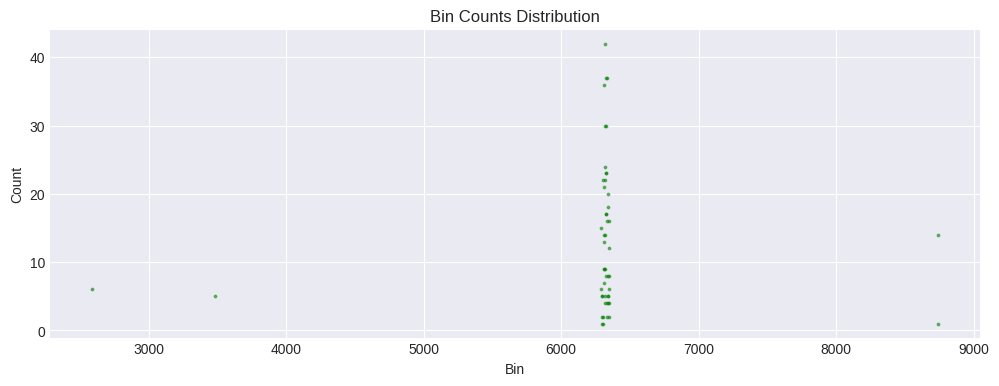

In [229]:
# Plotting
plt.style.use('seaborn-v0_8-darkgrid')  # Example style, replace with your preferred style
fig, ax = plt.subplots(figsize=(12, 4))

# Assuming bin_counts index is what you want on the x-axis and the values are what you want on the y-axis
ax.scatter(bin_counts.index, bin_counts.values, s=3, alpha=0.5, color='green')  # s controls the marker size, alpha controls transparency

ax.set_xlabel('Bin')  # Assuming 'Bin' is the appropriate label
ax.set_ylabel('Count')
ax.set_title('Bin Counts Distribution')

plt.show()